# Peter og ulven: Realistisk miljø

I vores situation kunne Peter bevæge sig rundt næsten uden at blive træt eller sulten. I en mere realistisk verden skal han sætte sig ned og hvile fra tid til anden, og han skal også sørge for at spise. Lad os gøre vores verden mere realistisk ved at implementere følgende regler:

1. Ved at bevæge sig fra et sted til et andet mister Peter **energi** og får noget **træthed**.
2. Peter kan få mere energi ved at spise æbler.
3. Peter kan slippe af med træthed ved at hvile under et træ eller på græsset (dvs. gå ind på en brætposition med et træ eller græs - grøn mark).
4. Peter skal finde og dræbe ulven.
5. For at dræbe ulven skal Peter have visse niveauer af energi og træthed, ellers taber han kampen.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from rlboard import *

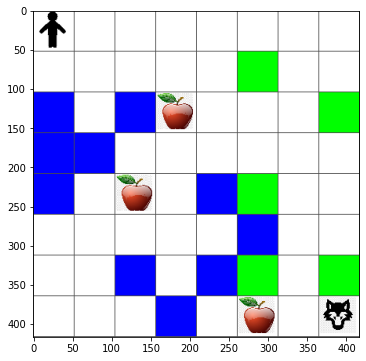

In [2]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

In [3]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

## Definere tilstand

I vores nye spilleregler skal vi holde styr på energi og træthed i hver brættilstand. Derfor vil vi oprette et objekt `state`, der vil indeholde alle nødvendige oplysninger om den aktuelle problemtilstand, inklusive brættets tilstand, aktuelle niveauer af energi og træthed, og om vi kan besejre ulven, når vi er i terminaltilstand:


In [4]:
class state:
    def __init__(self,board,energy=10,fatigue=0,init=True):
        self.board = board
        self.energy = energy
        self.fatigue = fatigue
        self.dead = False
        if init:
            self.board.random_start()
        self.update()

    def at(self):
        return self.board.at()

    def update(self):
        if self.at() == Board.Cell.water:
            self.dead = True
            return
        if self.at() == Board.Cell.tree:
            self.fatigue = 0
        if self.at() == Board.Cell.apple:
            self.energy = 10

    def move(self,a):
        self.board.move(a)
        self.energy -= 1
        self.fatigue += 1
        self.update()

    def is_winning(self):
        return self.energy > self.fatigue

Lad os prøve at løse problemet ved hjælp af random walk og se, om vi lykkes:


In [5]:
def random_policy(state):
    return random.choice(list(actions))

def walk(board,policy):
    n = 0 # number of steps
    s = state(board)
    while True:
        if s.at() == Board.Cell.wolf:
            if s.is_winning():
                return n # success!
            else:
                return -n # failure!
        if s.at() == Board.Cell.water:
            return 0 # died
        a = actions[policy(m)]
        s.move(a)
        n+=1

walk(m,random_policy)

0

In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        elif z==0:
            n+=1
        else:
            s+=1
    print(f"Killed by wolf = {w}, won: {s} times, drown: {n} times")

print_statistics(random_policy)

Killed by wolf = 5, won: 1 times, drown: 94 times


## Belønningsfunktion

En belønningsfunktion er en central komponent i forstærkningslæring, der guider agentens adfærd ved at tildele belønninger baseret på dens handlinger og tilstande. Den fungerer som en målestok for succes og hjælper agenten med at lære, hvilke handlinger der fører til ønskede resultater.

### Hvad er en belønningsfunktion?

En belønningsfunktion er en matematisk funktion, der kortlægger en agents tilstand og handling til en numerisk værdi, kaldet belønningen. Denne værdi repræsenterer, hvor godt agenten klarer sig i en given situation. 

### Design af en effektiv belønningsfunktion

At designe en effektiv belønningsfunktion er afgørende for at sikre, at agenten lærer den ønskede adfærd. Her er nogle vigtige overvejelser:

- **Klarhed og præcision**: Belønningsfunktionen skal klart definere, hvad der er ønsket adfærd.
- **Undgå utilsigtede incitamenter**: Sørg for, at belønningsfunktionen ikke utilsigtet belønner uønsket adfærd.
- **Skalerbarhed**: Belønningen skal være skaleret, så agenten kan skelne mellem små og store forbedringer.

### Eksempel på en simpel belønningsfunktion

Her er et eksempel på en simpel belønningsfunktion:

```python
def reward_function(state, action):
    if action == "desired_action":
        return 10  # Positiv belønning
    else:
        return -1  # Negativ belønning
```

I dette eksempel får agenten en positiv belønning for at udføre den ønskede handling og en negativ belønning for alle andre handlinger.

### Udfordringer ved belønningsfunktioner

Selvom belønningsfunktioner er kraftfulde, kan de også føre til udfordringer:

- **Belønningsmanipulation**: Agenten kan finde måder at maksimere belønningen på, som ikke stemmer overens med de ønskede mål.
- **Svært at definere**: I komplekse miljøer kan det være svært at definere en belønningsfunktion, der dækker alle scenarier.

### Konklusion

En veludformet belønningsfunktion er afgørende for succesfuld forstærkningslæring. Ved at forstå dens rolle og udfordringer kan du designe funktioner, der effektivt guider agentens læring og adfærd.


In [7]:
def reward(s):
    r = s.energy-s.fatigue
    if s.at()==Board.Cell.wolf:
        return 100 if s.is_winning() else -100
    if s.at()==Board.Cell.water:
        return -100
    return r

## Q-Learning algoritme

Selve læringsalgoritmen forbliver stort set uændret, vi bruger blot `state` i stedet for kun brættets position.


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

In [9]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

In [10]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    s = state(m)
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = s.board.human
        v = probs(Q[x,y])
        while True:
            a = random.choices(list(actions),weights=v)[0]
            dpos = actions[a]
            if s.board.is_valid(s.board.move_pos(s.board.human,dpos)):
                break 
        s.move(dpos)
        r = reward(s)
        if abs(r)==100: # end of game
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

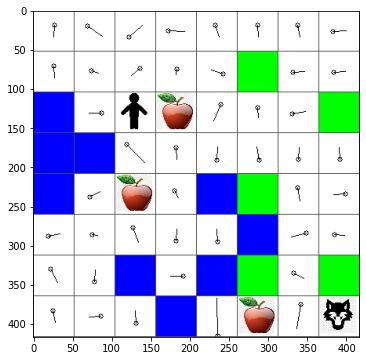

In [11]:
m.plot(Q)

## Resultater

Lad os se, om vi havde succes med at træne Peter til at bekæmpe ulven!


In [12]:
def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Killed by wolf = 1, won: 9 times, drown: 90 times


Vi ser nu meget færre tilfælde af drukning, men Peter er stadig ikke altid i stand til at dræbe ulven. Prøv at eksperimentere og se, om du kan forbedre dette resultat ved at lege med hyperparametrene.


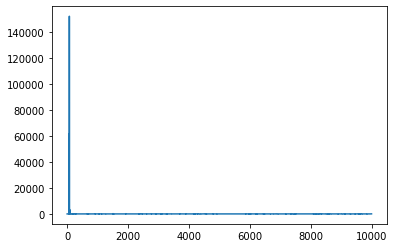

In [13]:
plt.plot(lpath)


---

**Ansvarsfraskrivelse**:  
Dette dokument er blevet oversat ved hjælp af AI-oversættelsestjenesten [Co-op Translator](https://github.com/Azure/co-op-translator). Selvom vi bestræber os på at sikre nøjagtighed, skal det bemærkes, at automatiserede oversættelser kan indeholde fejl eller unøjagtigheder. Det originale dokument på dets oprindelige sprog bør betragtes som den autoritative kilde. For kritisk information anbefales professionel menneskelig oversættelse. Vi påtager os ikke ansvar for eventuelle misforståelser eller fejltolkninger, der måtte opstå som følge af brugen af denne oversættelse.
